In [1]:
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from torch.utils.data import DataLoader

from mutation_dataset import MutationDataset
from nbvae import NBVAE, nbvae_loss

plt.style.use("dark_background")

/var/folders/yf/04w674ms20g4bzgz_4z_c6fm0000gp/T/ipykernel_49329/855251325.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Method
[Variational Autoencoders for Sparse and
Overdispersed Discrete Data](https://arxiv.org/pdf/1905.00616), which is designed to simulate sparse inputs better than a standard VAE.

### Data
Extracted from [cBioPortal](https://www.cbioportal.org/study/summary?id=breast_msk_2018) and contains VCFs for tumour genomes extracted from metastases of breast cancer. We've got around 2,000 samples in total, with 451 genes and 15 variant types sequenced.

In [2]:
PROJECT_ROOT = Path('/Users/jacobbradley/Documents/NBVAE')
RAW_BRCA_DATA = PROJECT_ROOT / 'data' / 'breast_msk_2018'

RAW_MUT_DATA = RAW_BRCA_DATA / 'data_mutations.txt'
RAW_SAMPLE_DATA = RAW_BRCA_DATA / 'data_clinical_sample.txt'

In [3]:
samples = pd.read_csv(RAW_SAMPLE_DATA, sep='\t', comment='#').set_index('SAMPLE_ID')
mutations = pd.read_csv(RAW_MUT_DATA, sep='\t', comment='#')
# mutations = mutations[mutations.Hugo_Symbol.isin(['TP53', 'KRAS', 'APC'])]
# mutations = mutations[mutations.Variant_Classification.isin(['Missense_Mutation', 'Nonsense_Mutation'])]

### Form Datasets

In [4]:
train_samples, val_samples = train_test_split(samples, test_size=.3, random_state=1234)

train_data = MutationDataset(mutations, samples=train_samples)
val_data = MutationDataset(mutations, samples=val_samples)

/Users/jacobbradley/Documents/NBVAE/mutation_dataset.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.simplified_mutations.replace({gene_col: self.gene_ids, variant_col: self.variant_ids}, inplace=True)
/Users/jacobbradley/Documents/NBVAE/mutation_dataset.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.simplified_mutations.replace({gene_col: self.gene_ids, variant_col: self.variant_ids}, inplace=True)
/Users/jacobbradley/Documents/NBVAE/mutation_dataset.py:34: FutureWarning: Downcasting behavior in `

### Train Model

In [5]:
lr = 3e-3
batch_size = 10
n_epochs = 50
kld_weight=1e-12

model = NBVAE(
    n_genes=len(train_data.genes), 
    n_variants=len(train_data.variants), 
    n_gene_signatures=2, 
    n_variant_signatures=5, 
    latent_dim=3
)
optimizer = Adam(model.parameters(), lr=lr)

In [6]:
print("Start training VAE...")
train_data.dense = True
val_data.dense = True
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    overall_train_loss = 0
    model.train()
    for train_batch_idx, train_batch in enumerate(DataLoader(train_data, batch_size=batch_size)):
        
        optimizer.zero_grad()

        batch_reconstruction_r, batch_reconstruction_p, mean, logvar = model(train_batch)
        loss = nbvae_loss(train_batch, batch_reconstruction_r, batch_reconstruction_p, mean, logvar, kld_weight)

        overall_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    overall_val_loss = 0
    model.eval()
    for val_batch_idx, val_batch in enumerate(DataLoader(val_data, batch_size=batch_size)):
        batch_reconstruction_r, batch_reconstruction_p, mean, logvar = model(val_batch)
        loss = nbvae_loss(val_batch, batch_reconstruction_r, batch_reconstruction_p, mean, logvar, kld_weight)
        overall_val_loss += loss.item()

    train_losses.append(overall_train_loss / train_batch_idx)
    val_losses.append(overall_val_loss / val_batch_idx)

    messages = [
        f"Epoch {epoch + 1} complete! "
        f"Average Train Loss: {train_losses[-1]: .3f}, " 
        f"Average Val Loss: {val_losses[-1]: .3f} "
    ]

    if val_losses[-1] == np.nanmin(val_losses):
        messages.append(f"(Saving Model)")
        saved_model = deepcopy(model)

    print(*messages)

print("Finish!!")

Start training VAE...
Epoch 1 complete! Average Train Loss:  1470.209, Average Val Loss:  337.696  (Saving Model)
Epoch 2 complete! Average Train Loss:  148.413, Average Val Loss:  80.536  (Saving Model)
Epoch 3 complete! Average Train Loss:  65.274, Average Val Loss:  53.170  (Saving Model)
Epoch 4 complete! Average Train Loss:  48.604, Average Val Loss:  43.566  (Saving Model)
Epoch 5 complete! Average Train Loss:  41.680, Average Val Loss:  38.490  (Saving Model)
Epoch 6 complete! Average Train Loss:  38.215, Average Val Loss:  36.327  (Saving Model)
Epoch 7 complete! Average Train Loss:  36.900, Average Val Loss:  35.202  (Saving Model)
Epoch 8 complete! Average Train Loss:  35.540, Average Val Loss:  34.696  (Saving Model)
Epoch 9 complete! Average Train Loss:  34.567, Average Val Loss:  33.977  (Saving Model)
Epoch 10 complete! Average Train Loss:  33.949, Average Val Loss:  33.221  (Saving Model)
Epoch 11 complete! Average Train Loss:  33.039, Average Val Loss:  32.232  (Saving 

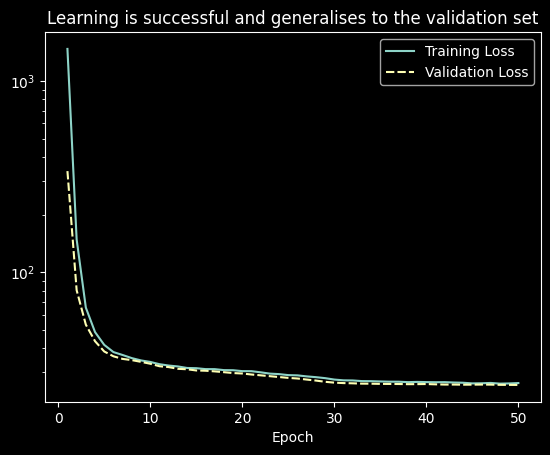

In [7]:
losses = pd.DataFrame({'Epoch': np.arange(1, n_epochs + 1), 'Training Loss': train_losses, 'Validation Loss': val_losses})
sns.lineplot(data=losses.set_index('Epoch'))
plt.yscale('log')
plt.title('Learning is successful and generalises to the validation set')
plt.show()

### Visualise Latents

In [8]:
val_vis_data = val_samples[['TMB_NONSYNONYMOUS', 'CANCER_TYPE_DETAILED', 'OVERALL_TUMOR_GRADE', 'ER_STATUS', 'SAMPLE_TYPE', 'SAMPLE_SITE']]
latents = [saved_model.get_latent(val_data[idx])[0].detach().tolist() for idx in range(len(val_samples))]
val_vis_data.loc[:, ['latent_1', 'latent_2', 'latent_3']] = pd.DataFrame(latents, columns=['latent_1', 'latent_2', 'latent_3'], index=val_vis_data.index)

In [9]:
fig = px.scatter_3d(val_vis_data, x='latent_1', y='latent_2', z='latent_3', color='SAMPLE_SITE')
fig.show()

In [10]:
fig = px.scatter_3d(val_vis_data, x='latent_1', y='latent_2', z='latent_3', color='TMB_NONSYNONYMOUS')
fig.show()

### Simulating 

True VCF (lightly mutated sample):

In [11]:
val_data.get_mutations('P-0012824-T01-IM5')

,Hugo_Symbol,Variant_Classification
Tumor_Sample_Barcode,,
P-0012824-T01-IM5,PIK3CA,Missense_Mutation


Simulated VCF (lightly mutated sample):

In [12]:
val_data.get_mutations(saved_model.sample_from_input(val_data['P-0012824-T01-IM5']))

,Hugo_Symbol,Variant_Classification
0,GATA3,Frame_Shift_Ins
1,TP53,Frame_Shift_Ins
2,ATM,Nonsense_Mutation


True VCF (heavily mutated sample):

In [13]:
val_data.get_mutations('P-0003054-T01-IM5')

,Hugo_Symbol,Variant_Classification
Tumor_Sample_Barcode,,
P-0003054-T01-IM5,ERBB2,Missense_Mutation
P-0003054-T01-IM5,PTEN,Frame_Shift_Del
P-0003054-T01-IM5,TP63,Nonsense_Mutation
P-0003054-T01-IM5,TP53,Missense_Mutation
P-0003054-T01-IM5,PIK3R3,Missense_Mutation
P-0003054-T01-IM5,SF3B1,Missense_Mutation
P-0003054-T01-IM5,PBRM1,Missense_Mutation
P-0003054-T01-IM5,EPHA3,Missense_Mutation
P-0003054-T01-IM5,ATR,Missense_Mutation


Simulated VCF (heavily mutated sample):

In [14]:
val_data.get_mutations(saved_model.sample_from_input(val_data['P-0003054-T01-IM5']))

,Hugo_Symbol,Variant_Classification
0,NOTCH1,Missense_Mutation
1,PTEN,Nonsense_Mutation
2,CDH1,Frame_Shift_Ins
3,RB1,Frame_Shift_Ins
4,TP53,Nonsense_Mutation
5,MGA,Missense_Mutation
6,TERT,Missense_Mutation
7,KDM6A,Frame_Shift_Del
8,INPP4B,Missense_Mutation
9,PTCH1,Missense_Mutation
